In [1]:
import os
import argparse
import tempfile
import json
import numpy as np
import pandas as pd
from google.cloud import bigquery, storage
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_fscore_support
import xgboost as xgb
# import mlflow
# import mlflow.xgboost
import joblib
import logging

## Loading Transformed & Engineered Features Data from the BigQuery Warehouse

In [2]:
from google.cloud import bigquery
import pandas as pd

# Initialize BigQuery client (assumes your notebook is authenticated)
client = bigquery.Client()

# Define your project and table details
PROJECT_ID = "olist-ecommerce-dw"  # Replace with your Project ID
DATASET_ID = "gold"
TABLE_ID = "agg_ltv_features" # Your final table name

# Query to select all data from the training table
QUERY = f"""
    SELECT *
    FROM `{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}`
      -- Exclude rows where features are null due to insufficient lookback (optional but safe)
"""

# Run the query and load the result into a Pandas DataFrame
df = client.query(QUERY).to_dataframe()

print(f"Loaded {len(df)} rows for training.")
df.head()

Loaded 2044 rows for training.


,seller_id,total_orders,total_spent,avg_order_value,recency_days,days_since_first_purchase,customer_tenure_days,avg_delivery_delay,pct_ontime_deliveries,avg_early_deliver_days,...,credit_pay_rate,avg_payment_installments,payment_match_rate,unique_products_bought,unique_categories_bought,avg_product_price,avg_freight_value,last_purchase_month,pct_orders_peak_season,ltv_6m
0,b86a47b3366e3b5424a7b225781f4908,1,106.35,106.35,102,102,0,14.0,1.0,13.33,...,1.0,1.0,1.0,1,0,87.0,20.0,1,0.0,0.0
1,7a704e63bb29c446869efde5d57524c8,1,109.90,109.90,82,82,0,19.0,1.0,18.92,...,1.0,2.0,1.0,1,1,94.0,15.0,1,0.0,0.0
2,c74f14c1e26cf1bd5bd34b6a1e274426,1,55.79,55.79,80,80,0,26.0,1.0,26.00,...,1.0,1.0,1.0,1,1,39.0,17.0,1,0.0,0.0
3,2ef086a599b597572aca4433b7ed6b3d,1,64.10,64.10,96,96,0,15.0,1.0,14.46,...,1.0,6.0,1.0,1,1,49.0,15.0,1,0.0,0.0
4,417a1e6c7321084d2a0ae0d023cfad93,1,61.38,61.38,76,76,0,17.0,1.0,16.46,...,1.0,1.0,1.0,1,1,49.0,12.0,1,0.0,0.0


## Analysis & Quality Check

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df.describe()

,total_orders,total_spent,avg_order_value,recency_days,days_since_first_purchase,customer_tenure_days,avg_delivery_delay,pct_ontime_deliveries,avg_early_deliver_days,avg_shipping_duration,...,credit_pay_rate,avg_payment_installments,payment_match_rate,unique_products_bought,unique_categories_bought,avg_product_price,avg_freight_value,last_purchase_month,pct_orders_peak_season,ltv_6m
count,2044.0,2.044000e+03,2044.000000,2044.0,2044.0,2044.0,2044.000000,2044.000000,2044.000000,2044.000000,...,2044.0,2044.000000,2044.0,2044.0,2044.0,2044.000000,2044.000000,2044.0,2044.000000,2044.000000
mean,50.359589,1.295435e+04,256.601795,74.802838,215.92319,141.120352,10.838596,0.896468,10.157965,13.895225,...,1.0,3.324843,1.0,11.696673,2.151174,173.541585,22.842955,4.84002,0.179130,2395.584462
std,156.416604,6.337561e+04,448.134213,96.157568,118.700887,125.012881,7.006901,0.199111,7.007255,6.894324,...,0.0,2.105066,0.0,24.459862,2.193557,304.168713,18.769444,2.949957,0.254424,7780.651343
min,1.0,2.400000e+01,13.630000,0.0,0.0,0.0,-58.000000,0.000000,-58.580000,1.000000,...,1.0,1.000000,1.0,1.0,0.0,3.000000,3.000000,1.0,0.000000,0.000000
25%,3.0,4.202250e+02,94.770000,5.0,119.75,15.75,8.200000,0.890000,7.530000,10.000000,...,1.0,1.887500,1.0,2.0,1.0,52.000000,15.000000,3.0,0.000000,0.000000
50%,10.0,1.898065e+03,153.970000,26.0,224.0,118.5,11.260000,0.980000,10.600000,12.825000,...,1.0,2.920000,1.0,4.0,1.0,94.000000,18.000000,4.0,0.071429,276.575000
75%,38.0,7.949670e+03,264.697500,123.0,337.0,249.0,14.382500,1.000000,13.690000,16.000000,...,1.0,4.160000,1.0,11.0,2.0,172.000000,23.000000,5.0,0.261059,1799.947500
max,3032.0,1.651019e+06,12871.370000,365.0,365.0,365.0,52.380000,1.000000,51.730000,86.000000,...,1.0,15.170000,1.0,414.0,25.0,6499.000000,228.000000,12.0,1.000000,143225.790000


In [5]:
(df["ltv_6m"]>0.1).sum()/df.shape[0]

0.6032289628180039

In [6]:
df.isna().sum()

seller_id                    0
total_orders                 0
total_spent                  0
avg_order_value              0
recency_days                 0
days_since_first_purchase    0
customer_tenure_days         0
avg_delivery_delay           0
pct_ontime_deliveries        0
avg_early_deliver_days       0
avg_shipping_duration        0
avg_review_score             0
review_count                 0
pct_positive_reviews         0
avg_response_time            0
credit_pay_rate              0
avg_payment_installments     0
payment_match_rate           0
unique_products_bought       0
unique_categories_bought     0
avg_product_price            0
avg_freight_value            0
last_purchase_month          0
pct_orders_peak_season       0
ltv_6m                       0
dtype: int64

* As can be seen, after cleaning process into GOLD layers, there's no invalid NULL values exist. This is really important to ensure data quality for the ML training.

In [7]:
df["churn_6m"] = df["ltv_6m"].apply(lambda x: 0 if x>0 else 1)
df["churn_6m"].value_counts(normalize=True)

churn_6m
0    0.603229
1    0.396771
Name: proportion, dtype: float64

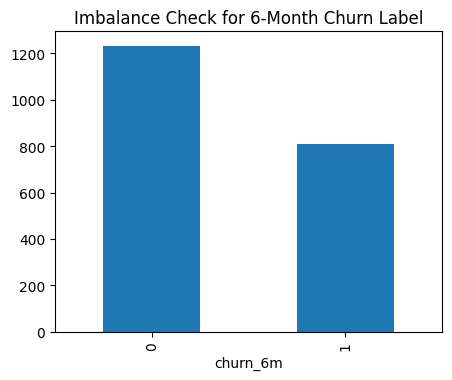

In [8]:
plt.figure(figsize = (5,3.9))
df["churn_6m"].value_counts().plot(kind="bar")
plt.title("Imbalance Check for 6-Month Churn Label")
plt.show()

* As can be seen, the balance ratio of churn class over non-churn is nearly 4:6, which is not too significant could be negligible considering imbalance.
* However, classification models should still apply weights on them while training.

## Training Preparation

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
df.columns

Index(['seller_id', 'total_orders', 'total_spent', 'avg_order_value',
       'recency_days', 'days_since_first_purchase', 'customer_tenure_days',
       'avg_delivery_delay', 'pct_ontime_deliveries', 'avg_early_deliver_days',
       'avg_shipping_duration', 'avg_review_score', 'review_count',
       'pct_positive_reviews', 'avg_response_time', 'credit_pay_rate',
       'avg_payment_installments', 'payment_match_rate',
       'unique_products_bought', 'unique_categories_bought',
       'avg_product_price', 'avg_freight_value', 'last_purchase_month',
       'pct_orders_peak_season', 'ltv_6m', 'churn_6m'],
      dtype='object')

In [11]:
features = [
   'total_orders', 'total_spent', 'avg_order_value',
   'recency_days', 'days_since_first_purchase', 'customer_tenure_days',
   'avg_delivery_delay', 'pct_ontime_deliveries', 'avg_early_deliver_days',
   'avg_shipping_duration', 'avg_review_score', 'review_count',
   'pct_positive_reviews', 'avg_response_time', 'credit_pay_rate',
   'avg_payment_installments', 'payment_match_rate',
   'unique_products_bought', 'unique_categories_bought',
   'avg_product_price', 'avg_freight_value', 'last_purchase_month',
   'pct_orders_peak_season'
]
target = 'churn_6m'

X = df[features]
y = df[target].values

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=6199)

## Model Baseline Testing & Training

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, average_precision_score, auc, roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

In [115]:
model_dict = {
    # "Logistic Regression": LogisticRegression(max_iter=100,random_state= 6199), Logistic Regression failed to converge
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=6199),
    "Random Forest" : RandomForestClassifier(n_estimators= 100, max_depth=5, random_state=6199),
    "XGBoost" : xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        n_estimators=100,             # Number of trees
        learning_rate=0.1,            # Step size shrinkage
        max_depth=5,                  # Tree depth
        # scale_pos_weight=imbalanced_ratio, # Handle class imbalance
        random_state=6199,
        n_jobs=-1
    )
}

In [182]:
def model_train_metrics(model_dict, X_train, X_test, y_train, y_test, features):
    eval_score = {}
    cm_dict = {}
    curve_auc, curve_pr = {}, {}
    features_ipt = {}
    trained_model = {}
    for name, model in model_dict.items():
        # Train & Predict label & probability classes (using a standard 0.5 threshold)
        model.fit(X_train, y_train)
        y_prob = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)

        # Calculate metrics
        f1 = f1_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        auc_roc = roc_auc_score(y_test, y_prob)
        pr_auc = average_precision_score(y_test, y_prob)
        # Confusion matrices
        cm = confusion_matrix(y_test, y_pred)
        # Precision & Recall Curves
        precision_pr, recall_pr, thresholds = precision_recall_curve(y_test, y_prob)
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)

        # Save metrics & confusion metrics in dictionary for later evaluation
        eval_score[name] = [precision, recall, f1, auc_roc, pr_auc]
        cm_dict[name] = cm
        curve_auc[name] = (fpr, tpr)
        curve_pr[name] = (precision_pr, recall_pr)
        features_ipt[name] = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False).rename("importance_score").reset_index()
        trained_model[name] = model
    return eval_score, cm_dict, curve_auc, curve_pr, features_ipt, trained_model
eval_score, cm_dict, curve_auc, curve_pr, features_ipt, trained_model = model_train_metrics(model_dict, X_train, X_test, y_train, y_test, features)

In [99]:
df_eval_score = pd.DataFrame(eval_score, index = ["Precision", "Recall", "F1-Score", "AUC ROC", "PR ROC"]).transpose()
df_eval_score

,Precision,Recall,F1-Score,AUC ROC,PR ROC
Decision Tree,0.755208,0.732323,0.743590,0.856988,0.772947
Random Forest,0.783069,0.747475,0.764858,0.899490,0.844914
XGBoost,0.746193,0.742424,0.744304,0.885016,0.843978


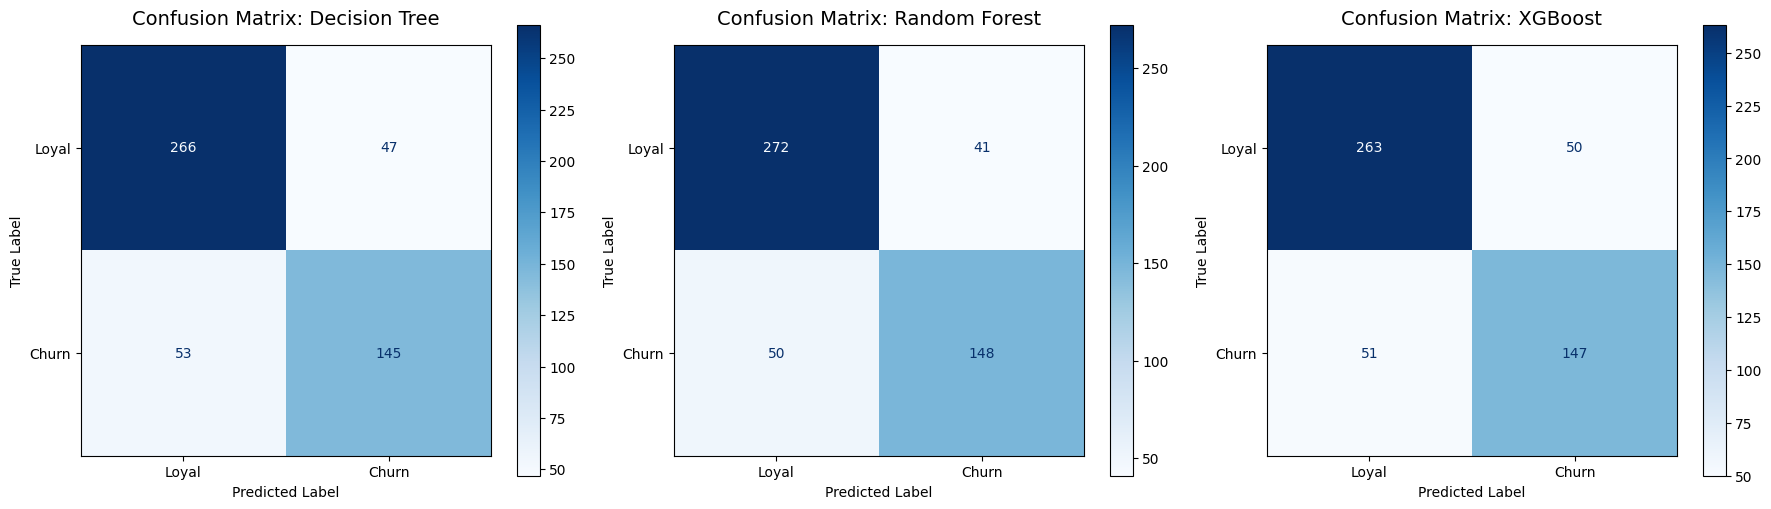

In [17]:
num_models = len(model_dict.keys())
class_labels = ['Loyal', 'Churn'] # order of classes is [0,1] 
fig, axes = plt.subplots(1, num_models, figsize = (6*num_models, 5))
for i, (name, cm) in enumerate(cm_dict.items()):
    # Create the ConfusionMatrixDisplay object
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

    # Use disp.plot(), passing the subplot axis (ax)
    disp.plot(
        cmap=plt.cm.Blues,
        ax=axes[i],
        values_format='d'
    )

    # Customize the title
    axes[i].set_title(f'Confusion Matrix: {name}', fontsize=14, y=1.03)
    # NOTE: disp.plot handles axis labels, but we can reset the True/Predicted labels for clarity
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')
# Adjust layout
plt.tight_layout()
plt.show()

* As can be seen, the Random Forest model has the highest F1-Score (0.765) and the highest AUC ROC (0.899). This indicates that it provides the best balance of Precision and Recall, and is also the most effective model at correctly separating the positive and negative classes.
* The Random Forest model also achieved the highest scores for both Precision (0.783) and Recall (0.747). This means it is the best at minimizing both false positive (FP) and false negative (FN) predictions simultaneously.
* Both the Random Forest (0.845) and XGBoost (0.844) models show a strong, nearly identical performance on the PR ROC curve. This suggests that both ensemble methods are robust when dealing with a potentially imbalanced dataset, significantly outperforming the single Decision Tree (0.773).

-> With the higher model's complexity, Random Forest & XGBoost are selected for further Hyperparameters Tunning

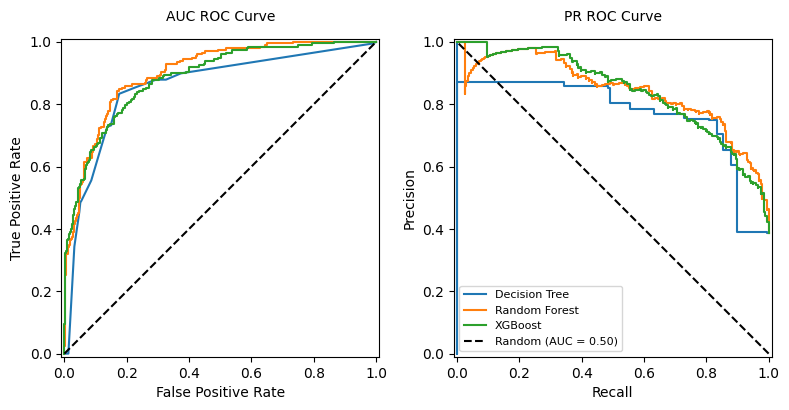

In [18]:
fig, axes = plt.subplots(1, 2, figsize = (8, 6))
for name, (fpr, tpr) in curve_auc.items():
    disp = RocCurveDisplay(fpr=fpr, tpr=tpr, name=name)
    disp.plot(ax=axes[0])
axes[0].set_title("AUC ROC Curve", fontsize=10, y=1.03)
axes[0].plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')
axes[0].legend([],[], frameon=False)

for name, (precision_pr, recall_pr) in curve_pr.items():
    disp = PrecisionRecallDisplay(precision=precision_pr, recall=recall_pr, estimator_name=name)
    disp.plot(ax=axes[1])
axes[1].set_title("PR ROC Curve", fontsize=10, y=1.03)
axes[1].plot([1, 0], [0, 1], 'k--', label='Random (AUC = 0.50)')
axes[1].legend(fontsize=8)
plt.tight_layout()
plt.show()

## Features Importances & Features Selection

In [73]:
df_ipt = pd.merge(left=features_ipt["Random Forest"], right=features_ipt["XGBoost"], on="index")
df_ipt = df_ipt.rename(columns=dict(zip(df_ipt.columns, ["Features", "Random Forest", "XGBoost"])))
df_ipt = df_ipt.sort_values(by="Random Forest", ascending=False)
# df_ipt

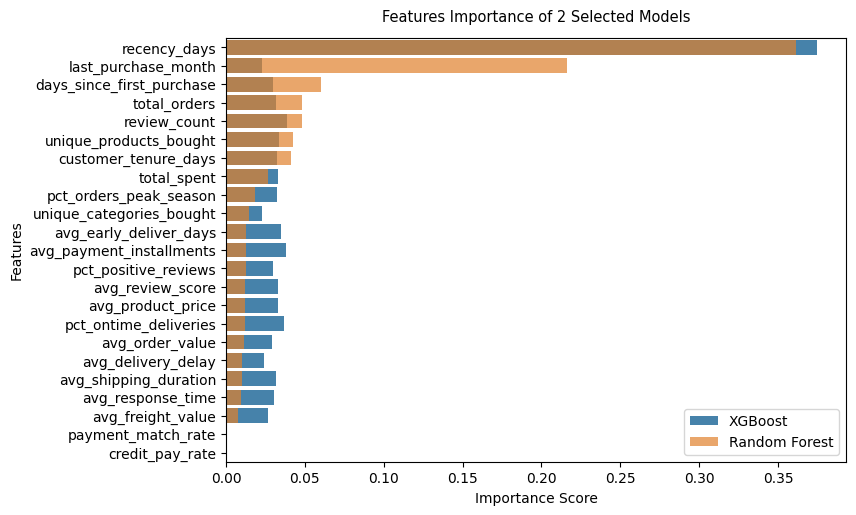

In [76]:
plt.figure(figsize=(8,5.5))
sns.barplot(data=df_ipt, y="Features", x="XGBoost", color="#1F77B4", alpha=0.9, label="XGBoost")
sns.barplot(data=df_ipt, y="Features", x="Random Forest", color="#FF7F0E", alpha=0.7, label="Random Forest")
plt.title("Features Importance of 2 Selected Models", fontsize=10.5, y=1.02)
plt.xlabel("Importance Score")
plt.show()

* As can be seen, Random Forest give significant scores over 8 highest scores, while XGBoost has almost idential scores over the majority of the features.
* Moreover, both models consider recency_days as the most important feature, payment_match_rate and credit_payrate as the most negligible ones. This demonstrates the importance of purchase time-related columns and unimportance of payment behavior ones.

In [180]:
selected_feas = df_ipt.nlargest(5, 'Random Forest')["Features"].values
selected_feas

array(['recency_days', 'last_purchase_month', 'days_since_first_purchase',
       'total_orders', 'review_count'], dtype=object)

In [177]:
# model_slc = model_dict.pop("Decision Tree")

In [184]:
X_fi = df[selected_feas]
y_fi = df[target].values
X_train_fi, X_test_fi, y_train_fi, y_test_fi = train_test_split(X_fi, y_fi, test_size=0.25, random_state=6199)
eval_score_fi, cm_dict_fi, curve_auc_fi, curve_pr_fi, features_ipt_fi, trained_model_fi = model_train_metrics(model_dict=model_dict, X_train=X_train_fi, X_test=X_test_fi, y_train=y_train_fi, y_test=y_test_fi, features=selected_feas)

In [185]:
df_eval_score = pd.DataFrame(eval_score_fi, index = ["Precision", "Recall", "F1-Score", "AUC ROC", "PR ROC"]).transpose()
df_eval_score

,Precision,Recall,F1-Score,AUC ROC,PR ROC
Random Forest,0.758294,0.808081,0.782396,0.895367,0.855890
XGBoost,0.772727,0.772727,0.772727,0.881660,0.833329


* The metrics show a significant improvement in both recall (reached high sensitivity of 0.808) and f1-score (higher harmonic mean of recall and precision of 0.782) of Random Forest after top-5 features selection. 
* XGBoost can nearly obtain the same performance using up to 8 features, which demonstrates the even weak scores it gives cross the majority of features, as can be shown in the previous plot. 
* The lower features to be extracted, the lower the cost for training session. This highlights the advantage and performance of Random Forest, and that makes this model officially chosen to resolve Churn Prediction.   

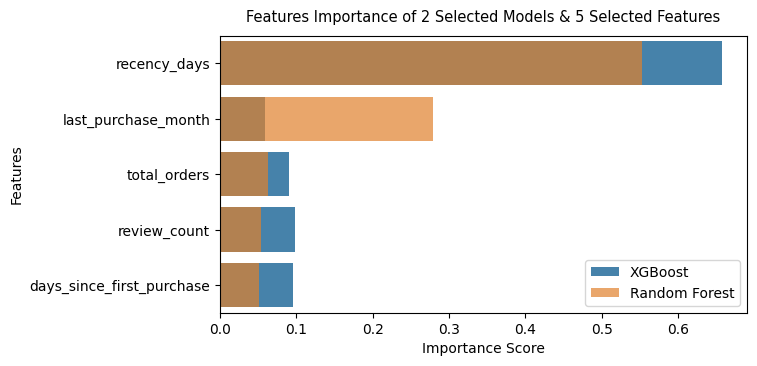

In [170]:
df_ipt_fi = pd.merge(left=features_ipt_fi["Random Forest"], right=features_ipt_fi["XGBoost"], on="index")
df_ipt_fi = df_ipt_fi.rename(columns=dict(zip(df_ipt_fi.columns, ["Features", "Random Forest", "XGBoost"])))
df_ipt_fi = df_ipt_fi.sort_values(by="Random Forest", ascending=False)
plt.figure(figsize=(6.8,3.6))
sns.barplot(data=df_ipt_fi, y="Features", x="XGBoost", color="#1F77B4", alpha=0.9, label="XGBoost")
sns.barplot(data=df_ipt_fi, y="Features", x="Random Forest", color="#FF7F0E", alpha=0.7, label="Random Forest")
plt.title("Features Importance of 2 Selected Models & 5 Selected Features", fontsize=10.5, y=1.02)
plt.xlabel("Importance Score")
plt.show()

## Save the Pretrained Random Forest

In [186]:
import joblib
# 1. Define the filename
filename = 'random_forest_model.joblib'
selected_model = trained_model_fi["Random Forest"]
# 2. Save the model to disk
joblib.dump(selected_model, filename)

['random_forest_model.joblib']

* joblib is optimized for handling Python objects that contain large NumPy arrays (like the structures inside a RandomForest or any scikit-learn estimator)

## Hyperparameters Tunning

In [77]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
# from skopt import BayesSearchCV
# from skopt.space import Integer, Categorical, Real

In [171]:
# # 1. Model Definition
# rf_model = RandomForestClassifier(random_state=6199)
# # 2. Define the parameter distribution space
# # Use a dictionary where keys are parameter names and values are distributions or lists.
# # 'randint' is a useful distribution for integer parameters.
# param_dist_rf = {
#     'n_estimators': randint(low=50, high=150),           # Number of trees (e.g., 50 to 300)
#     'max_depth': randint(low=10, high=25),                    # Maximum depth of trees
#     'min_samples_split': randint(low=5, high=11),       # Min samples required to split a node
#     'max_features': ['sqrt', 'log2']               # Number of features to consider for a split
# }
# # 3. Create and run Randomized Search
# # n_iter: number of parameter settings that are sampled (the budget)
# # cv: number of cross-validation folds
# # verbose: controls the verbosity
# random_search_rf = RandomizedSearchCV(
#     estimator=rf_model,
#     param_distributions=param_dist_rf,
#     n_iter=20,  # Try 50 random combinations
#     cv=5,       # 5-fold cross-validation
#     scoring='f1_weighted',
#     n_jobs=-1,  # Use all available cores
#     random_state=6199
# )

# # Fit the random search to the data
# random_search_rf.fit(X_fi, y_fi)

# # 4. Print the best results
# print("Random Forest Results:")
# print(f"Best Score (F1-Score): {random_search_rf.best_score_:.4f}")
# print("Best Hyperparameters:", random_search_rf.best_params_)